# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import os

import warnings

warnings.filterwarnings(action='ignore')

# Introduction

Misinformation has rapidly become a widespread concern. Fake news is easier than ever to circulate due to social media and the dismantling of fact-checking systems. In a turbulent time when new information is constantly emerging, the ability to discern fact from fiction is increasingly crucial. Thus, this project aims to create a model that can distinguish between fake and real news.

The dataset is sourced from Kaggle and can be found at this (link)[https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv]. It includes two files, one containing fake news and the other containing real news, each with four columns: title, text, subject, and date. We combined both files into one and added a column to label each article as fake and real. Using the text and label of each article, we utilized various embedding techniques to train classification models.

# Data Processing

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", path)

# import the data
fake_news = pd.read_csv(os.path.join(path,"Fake.csv"))
true_news = pd.read_csv(os.path.join(path,"True.csv"))

# view first few rows for each
print(fake_news.head())
print(true_news.head())

Path to dataset files: /Users/elliehuang/.cache/kagglehub/datasets/clmentbisaillon/fake-and-real-news-dataset/versions/1
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  
                   

In [3]:
# add labels
fake_news["label"] = "Fake"
true_news["label"] = "True"

# combine the two separate dataframes
news_df = pd.concat([fake_news, true_news], ignore_index = True)

# Data Cleaning


In [4]:
import string

# checking for missing values
print(news_df.isna().sum())

# converting letters to lowercase
news_df["text"] = news_df["text"].str.lower()

# removing punctuation
news_df["text"] = news_df["text"].str.replace("[{}]".format(string.punctuation), "", regex = True)

# removing other special characters
news_df["text"] = news_df["text"].apply(lambda x: x.encode("ascii", "ignore").decode("utf-8"))

# view cleaned dataset
print(news_df.head())

title      0
text       0
subject    0
date       0
label      0
dtype: int64
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  donald trump just couldn t wish all americans ...    News   
1  house intelligence committee chairman devin nu...    News   
2  on friday it was revealed that former milwauke...    News   
3  on christmas day donald trump announced that h...    News   
4  pope francis used his annual christmas day mes...    News   

                date label  
0  December 31, 2017  Fake  
1  December 31, 2017  Fake  
2  December 30, 2017  Fake  
3  December 29, 2017  Fake  
4  December 25, 2017  Fake  


In [5]:
# tokenizing article text into words
tokenized_news = [nltk.word_tokenize(article) for article in news_df["text"]]

In [6]:
# removing stopwords
stop_words = set(stopwords.words("english"))

cleaned_articles = [[word for word in article if word not in stop_words] 
    for article in tokenized_news]

news_df["text"] = [" ".join(article) for article in cleaned_articles]
print((news_df["text"].head()))

0    donald trump wish americans happy new year lea...
1    house intelligence committee chairman devin nu...
2    friday revealed former milwaukee sheriff david...
3    christmas day donald trump announced would bac...
4    pope francis used annual christmas day message...
Name: text, dtype: object


# EDA


Most common words overall 

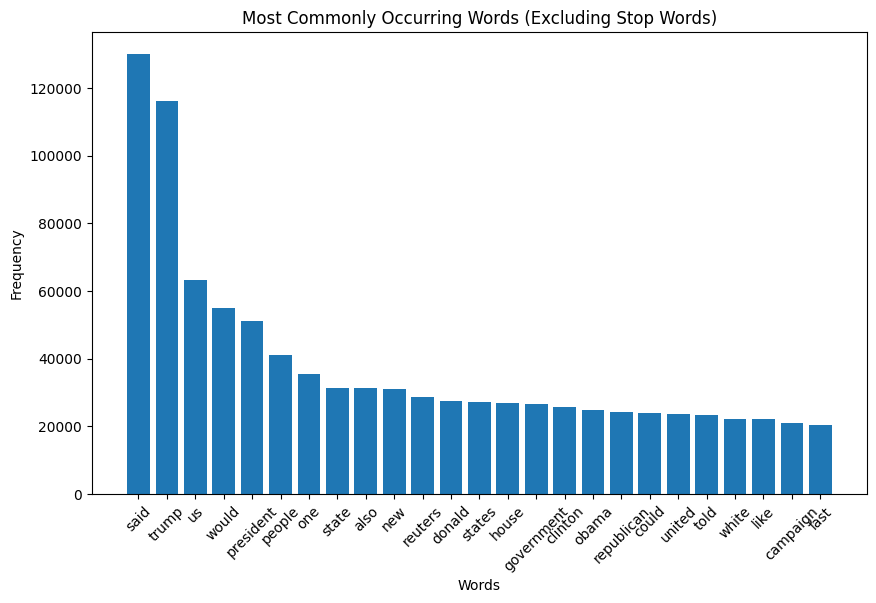

In [7]:
from collections import Counter
all_words = [word for article in cleaned_articles for word in article]
word_counts = Counter(all_words)

common_words = word_counts.most_common(25) 
words, counts = zip(*common_words)

plt.figure(figsize = (10,6))
plt.bar(words, counts)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Commonly Occurring Words (Excluding Stop Words)")
plt.xticks(rotation = 45)
plt.show()

Most common words in fake vs. true articles

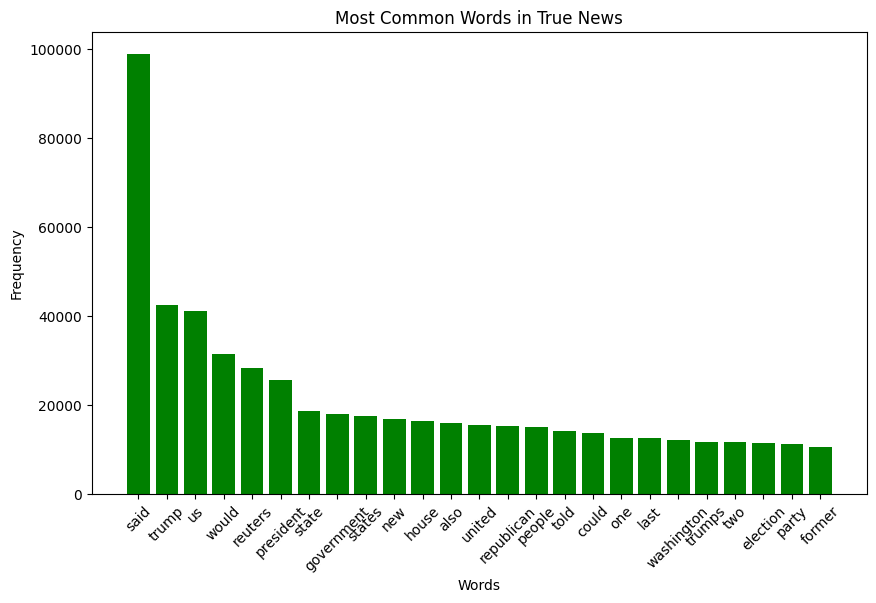

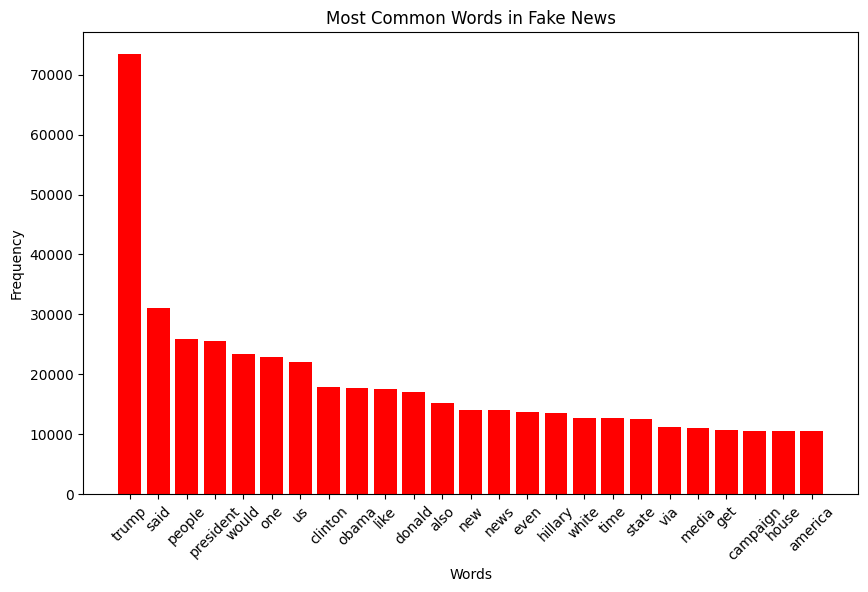

In [8]:
fake_articles = news_df[news_df.label == "Fake"]
fake_tokenized = [nltk.word_tokenize(article) for article in fake_articles["text"]]
fake_cleaned = [[word for word in article if word not in stop_words] 
    for article in fake_tokenized]
fake_words = [word for article in fake_cleaned for word in article]

true_articles = news_df[news_df.label == "True"]
true_tokenized = [nltk.word_tokenize(article) for article in true_articles["text"]]
true_cleaned = [[word for word in article if word not in stop_words] 
    for article in true_tokenized]
true_words = [word for article in true_cleaned for word in article]

fake_word_counts = Counter(fake_words)
true_word_counts = Counter(true_words)

fake_most_common = fake_word_counts.most_common(25) 
fake_words, fake_counts = zip(*fake_most_common)
true_most_common = true_word_counts.most_common(25) 
true_words, true_counts = zip(*true_most_common)

# plotting most common words in true articles
plt.figure(figsize = (10, 6))
plt.bar(true_words, true_counts, color="green")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Common Words in True News")
plt.xticks(rotation = 45)
plt.show()

# plotting most common words in fake articles
plt.figure(figsize = (10, 6))
plt.bar(fake_words, fake_counts, color="red")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Common Words in Fake News")
plt.xticks(rotation = 45)
plt.show()

From the above graphs, we can see the difference in the most common words for fake vs. true news articles. "Election," "republican," "house," "reuters," and "could" seem to be more common in the true news. Meanwhile, "clinton," "obama," "donald," "white," "media," and "campaign" seem to be more common in the fake news. 

Creating a wordcloud: the more common words in the fake news are shown in red, the more common words in true news are shown in green, and the common words in both are shown in gray. "Trump" seems to be the dominant word in both datasets.

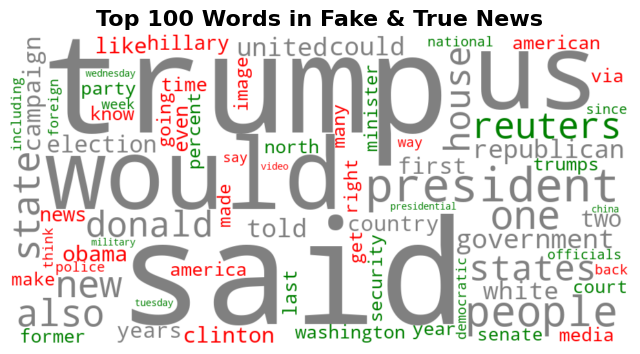

In [9]:
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import Word

# create dictionaries for word frequencies
fake_top_words = dict(fake_word_counts.most_common(50))
true_top_words = dict(true_word_counts.most_common(50))

# merge word counts while keeping track of origins
combined_word_counts = {word: fake_top_words.get(word, 0) + true_top_words.get(word, 0)
                        for word in set(fake_top_words) | set(true_top_words)}

# custom function to color words based on their origin
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    if word in fake_top_words and word in true_top_words:
        return "rgb(128, 128, 128)"  # gray for shared words
    elif word in fake_top_words:
        return "rgb(255, 0, 0)"  # red for fake news words
    elif word in true_top_words:
        return "rgb(0, 128, 0)"  # green for true news words
    return "rgb(0, 0, 0)"  

# generate word cloud
wordcloud = WordCloud(
    width = 900, height = 450, max_words = 100, background_color = "white"
).generate_from_frequencies(combined_word_counts)

# apply custom coloring 
wordcloud.recolor(color_func = color_func)
 
# plotting the wordcloud
plt.figure(figsize = (8, 5))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Top 100 Words in Fake & True News", fontsize = 16, fontweight = "bold")
plt.show()

Finding the most common bigrams within the text:

In [10]:
from nltk.util import bigrams

def extract_bigrams(text):
    words = [word for word in nltk.word_tokenize(text.lower()) if word.isalnum() and word not in stop_words]
    return list(bigrams(words))

# Extract bigrams from each review
all_bigrams = []
for article in news_df["text"]:
    all_bigrams.extend(extract_bigrams(article))

# Convert bigrams to string format
bigram_strings = [" ".join(bigram) for bigram in all_bigrams]

# Count bigrams
bigram_counts = Counter(bigram_strings)

# Get top 30 bigrams
top_bigrams = pd.DataFrame(bigram_counts.most_common(30), columns=["bigram", "count"])
print(top_bigrams.head())

            bigram  count
0     donald trump  21047
1    united states  18354
2      white house  14571
3  hillary clinton   8864
4         new york   8515


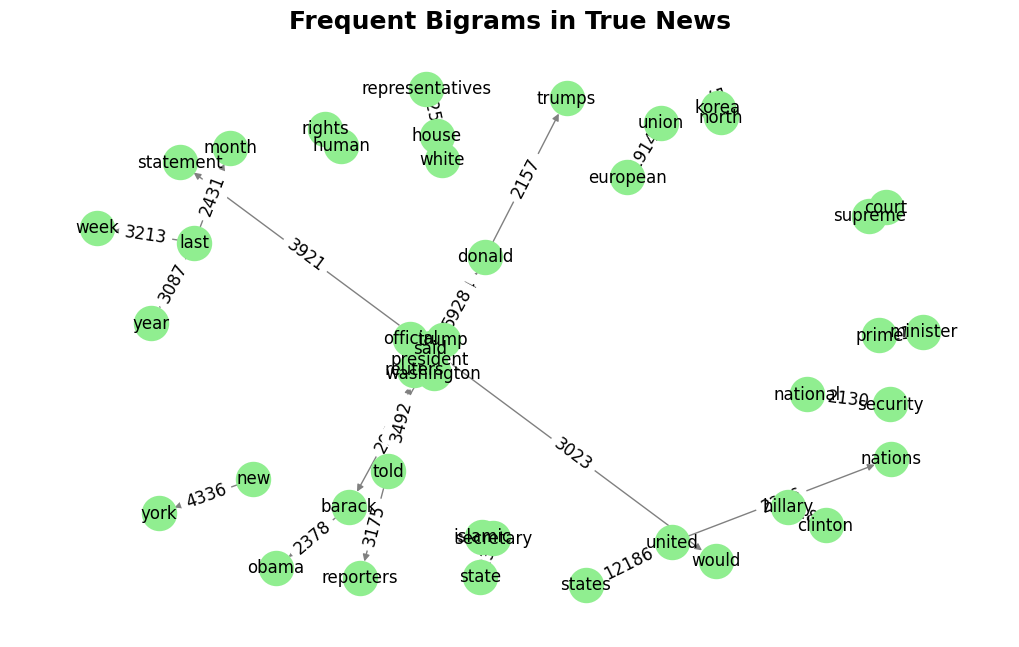

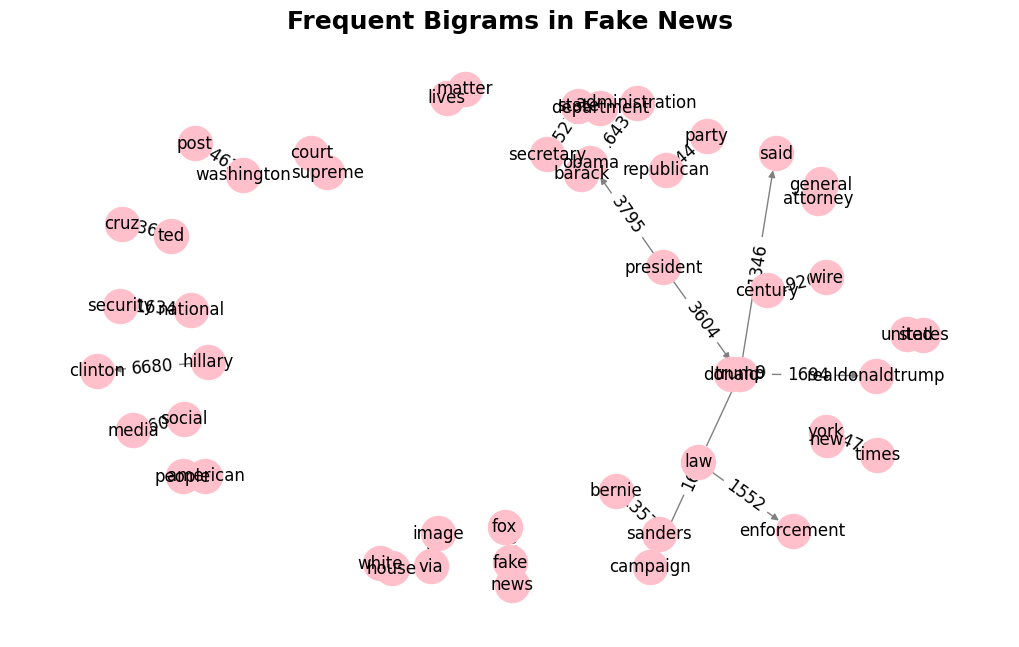

In [11]:
from itertools import islice
import networkx as nx
from nltk.tokenize import word_tokenize

# function to process bigrams

def get_top_bigrams(df, label, top_n = 30):
    stop_words = set(stopwords.words('english'))
    
    df = df[df['label'] == label]
    
    bigrams = []
    for text in df['text'].dropna():  # remove na values
        words = [word.lower() for word in word_tokenize(str(text)) if word.isalpha()]
        words = [word for word in words if word not in stop_words and len(word) > 2]  # remove stopwords
        bigrams.extend(zip(words, islice(words, 1, None)))  # create bigrams
        
    bigram_counts = Counter(bigrams)
    
    # select only the top n bigrams
    top_bigrams = dict(bigram_counts.most_common(top_n))
    
    return top_bigrams

# get top 30 bigrams for TRUE and FAKE news
true_bigrams = get_top_bigrams(news_df, "True", top_n=30)
fake_bigrams = get_top_bigrams(news_df, "Fake", top_n=30)

# function to plot bigram graph
def plot_bigram_graph(bigrams, title, color):
    G = nx.DiGraph()
    
    for (word1, word2), count in bigrams.items():
        G.add_edge(word1, word2, weight = count)
    
    plt.figure(figsize = (10, 6))
    pos = nx.spring_layout(G, k = 1.5) 
    edges = G.edges(data = True)
    
    nx.draw(G, pos, node_color = color, edge_color = 'gray', with_labels = True, 
            node_size = 600, font_size = 12) 
    
    # draw edge labels (weights)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in edges}, 
                                 font_size = 12) 
    
    plt.title(title, fontsize = 18, fontweight = "bold") 
    plt.show()

# plot true news bigram graph
plot_bigram_graph(true_bigrams, "Frequent Bigrams in True News", color = "lightgreen")

# plot fake news bigram graph
plot_bigram_graph(fake_bigrams, "Frequent Bigrams in Fake News", color = "pink")

The true news bigram graph features terms such as "state secretary", "national security", "prime minister", and "human rights," suggesting coverage of political events, government policies, and international affairs. The presence of "donald trump", "barack obama", and "hillary clinton" indicates reporting on prominent political figures. Additionally, "united states", "north korea", and "european union" point to coverage of global geopolitics. Overall, the true news bigram graph a structured and distributed network with central terms related to governance and diplomacy.

In contrast, the fake news bigram graph displays a looser, more fragmented structure with clusters. The frequent occurrence of "fake news", "media social", and "realdonald trump" suggests possible misinformation and social media discourse. This network includes "bernie sanders", "ted cruz", and "campaign", indicating a focus on less prominent political figures. Additionally, phrases like "attorney general", "supreme court", and "law enforcement" display that legal and judicial topics are common.

# Methods

## Tf-idf

TF-IDF (Term Frequency-Inverse Document Frequency) is a weighting technique used in NLP and information retrieval to identify the significance of a word within a document relative to a larger corpus. It consists of two components: term frequency (TF), which measures how often a word appears in a document, and inverse document frequency (IDF), which reduces the weight of words that appear frequently across multiple documents. By combining these factors, TF-IDF assigns higher scores to terms that are important within a specific document but not overly common across the entire dataset, making it useful for tasks such as keyword extraction and text classification.

In [12]:
# data pre-processing
corpus = news_df["text"]
tokenized_corpus = [simple_preprocess(sentence) for sentence in corpus]

stop_words = set(stopwords.words('english'))  # NLTK stop words

filtered_corpus = [
    [word for word in sentence if word.lower() not in stop_words]
    for sentence in tokenized_corpus
]

X = news_df["text"]
y = news_df["label"]

# splitting into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 20, stratify = y)

In [13]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data (no fitting on test data)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Here are the top 10 tf-idf values. 

In [14]:
# get feature names (words)
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# find the max tf-idf values without converting to a dense array
top_n = 10
max_tfidf_values = X_train_tfidf.max(axis=0).toarray().ravel() 

# get indices of the top TF-IDF values
sorted_indices = np.argsort(max_tfidf_values)[-top_n:][::-1]  # top N highest values

# extract words and corresponding TF-IDF scores
top_words = feature_names[sorted_indices]
top_values = max_tfidf_values[sorted_indices]

# display results in a dataframe
df_top_tfidf = pd.DataFrame({"Word": top_words, "TF-IDF Value": top_values})
print(df_top_tfidf)

                                                Word  TF-IDF Value
0  httpsfedupwpenginecomwpcontentuploads201504hil...           1.0
1   httpswwwyoutubecomwatchtimecontinue1vneqmsi6or5q           1.0
2                httpswwwyoutubecomwatchvrur8pyr5axs           1.0
3   httpswwwyoutubecomwatchtimecontinue2vijwclqckhd8           1.0
4                httpswwwyoutubecomwatchvsh0prtk9sae           1.0
5            httpswwwyoutubecomwatchvhnpx8zcifc0t26s           1.0
6                httpswwwyoutubecomwatchvsmhgkzrwzkg           1.0
7                httpswwwyoutubecomwatchv0cvugq2gbbk           1.0
8                httpswwwyoutubecomwatchvipqrimr8gww           1.0
9                httpswwwyoutubecomwatchv31mrqr9yduu           1.0


The top TF-IDF values are predominantly links, which were not removed during the original data cleaning. These have high TF-IDF values, likely because URLs are unique or rare within articles, causing TF-IDF to assign them high importance. Since these do not contribute meaningful linguistic information for classification, they should be removed during preprocessing.

In [15]:
# function for removing links
def remove_urls(text):
    return re.sub(r'http[s]?://\S+', '', text)  

# apply
X_train = [remove_urls(text) for text in X_train]
X_test = [remove_urls(text) for text in X_test]
X = X.apply(remove_urls)

# reinitialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### Fit models 

For modeling, we selected logistic regression and a support vector machine (SVM) with a linear kernel due to their effectiveness in handling high-dimensional text data, particularly when using features such as TF-IDF. By using both models, we can compare their performance and assess whether a simple probabilistic approach (logistic regression) or a margin-based classifier (SVM) is more effective for our dataset.

#### Logistic regression model

In [16]:
# Train logistic regression model
clf_tfidf = LogisticRegression()
clf_tfidf.fit(X_train_tfidf, y_train)

# Predict on test data
y_pred_lr_tfidf = clf_tfidf.predict(X_test_tfidf)

# Evaluate accuracy
accuracy_lr_tfidf = accuracy_score(y_test, y_pred_lr_tfidf)

#### SVM with linear kernel

In [17]:
# Initialize the SVM classifier
svm_model = SVC(kernel='linear')

# Fit the SVM model on the TF-IDF transformed training data
svm_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_svm_tfidf = svm_model.predict(X_test_tfidf)

# Evaluate accuracy
accuracy_svm_tfidf = accuracy_score(y_test, y_pred_svm_tfidf)

print(f"The accuracy for Logistic Regression is {accuracy_lr_tfidf: .4f}, the accuracy for SVM Linear is {accuracy_svm_tfidf: .4f}.")

The accuracy for Logistic Regression is  0.9882, the accuracy for SVM Linear is  0.9950.


## Word2Vec

Word2Vec is a word embedding technique that uses shallow neural networks to map words to vectors such that similar words are closer together. This ensures that the semantic meaning is captured by the embedding since words with similar meanings have similar vector representations. There are two main models that fall under Word2Vec: continuous bag of words (CBOW) and skip-gram.

CBOW predicts the target words based on its surrounding context. Given an input of surrounding words within a certain window of the target word, the model predicts the target word.

Skip-gram is the reverse of CBOW. Given a word, the model determines what the surrounding context is. We tried both embedding techniques to determine which one would enhance performance.

## Run and Save Embeddings

In [18]:
model_cbow = Word2Vec(sentences=filtered_corpus, vector_size=100, window=5, min_count=1, workers=4, sg=0)
model_sg = Word2Vec(sentences=filtered_corpus, vector_size=100, window=5, min_count=1, workers=4, sg=1)

# Parameters:
# - vector_size: Dimensionality of word embeddings
# - window: Context window size
# - min_count: Ignores words appearing less than min_count times
# - workers: Number of CPU cores to use
# - sg: 0 for CBOW (Continuous Bag of Words), 1 for Skip-gram

model_cbow.save("word2vec_cbow.model")
model_sg.save("word2vec_sg.model")

### Fit models

### CBOW

In [19]:
# Load the model
cbow = Word2Vec.load("word2vec_cbow.model")

def sentence_to_vector(sentence, model):
    """Convert a sentence to a vector by averaging word embeddings."""
    words = simple_preprocess(sentence)  # Tokenization
    word_vectors = [model.wv[word] for word in words if word in model.wv]

    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Average word vectors
    else:
        return np.zeros(model.vector_size)  # Return a zero vector if no words are in the model

X_vectors_cbow = np.array([sentence_to_vector(sentence, cbow) for sentence in X])

# train-test split
X_train_cbow, X_test_cbow, y_train, y_test = train_test_split(X_vectors_cbow, y, test_size = 0.25, random_state = 20, stratify = y)

#### Logistic regression model

In [20]:
# Train logistic regression model
clf_cbow = LogisticRegression()
clf_cbow.fit(X_train_cbow, y_train)

# Predict on test data
y_pred_lr_cbow = clf_cbow.predict(X_test_cbow)

# Evaluate accuracy
accuracy_lr_cbow = accuracy_score(y_test, y_pred_lr_cbow)

#### SVM with linear kernel

In [21]:
# Train Linear SVM model
svm_cbow_model = SVC(kernel="linear")
svm_cbow_model.fit(X_train_cbow, y_train)

# Predict on test data
y_pred_svm_cbow = svm_cbow_model.predict(X_test_cbow)

# Evaluate accuracy
accuracy_svm_cbow = accuracy_score(y_test, y_pred_svm_cbow)

print(f"The accuracy for Logistic Regression is {accuracy_lr_cbow: .4f}, the accuracy for SVM Linear is {accuracy_svm_cbow: .4f}.")

The accuracy for Logistic Regression is  0.9632, the accuracy for SVM Linear is  0.9637.


### Skip-gram

In [22]:
sg = Word2Vec.load("word2vec_sg.model")

X_vectors_sg = np.array([sentence_to_vector(sentence, sg) for sentence in X])

# train-test split
X_train_sg, X_test_sg, y_train, y_test = train_test_split(X_vectors_sg, y, test_size = 0.25, random_state = 20, stratify = y)

#### Logistic regression model

In [23]:
# Train logistic regression model
clf_sg = LogisticRegression()
clf_sg.fit(X_train_sg, y_train)

# Predict on test data
y_pred_lr_sg = clf_sg.predict(X_test_sg)

# Evaluate accuracy
accuracy_lr_sg = accuracy_score(y_test, y_pred_lr_sg)

#### SVM with linear kernel

In [24]:
# Train Linear SVM model
svm_model_sg = SVC(kernel="linear")
svm_model_sg.fit(X_train_sg, y_train)

# Predict on test data
y_pred_svm_sg = svm_model_sg.predict(X_test_sg)

# Evaluate accuracy
accuracy_svm_sg = accuracy_score(y_test, y_pred_svm_sg)

print(f"The accuracy for Logistic Regression is {accuracy_lr_sg: .4f}, the accuracy for SVM Linear is {accuracy_svm_sg: .4f}.")

The accuracy for Logistic Regression is  0.9609, the accuracy for SVM Linear is  0.9653.


## GloVe

Global Vectors for Word Representation, or GloVe for short, is a word embedding technique created by Stanford researchers Jeffrey Pennington, Richard Socher, and Christopher D. Manning that captures the meaning of words by analyzing word co-occurrence statistics in a large corpus. In other words, GloVe is a way to turn words into numbers by looking at how often words appear together in a large collection of text. However, unlike the other word2vec methods like CBOW and skip-gram, which learn embeddings through local context windows, GloVe constructs word vectors based on global word co-occurrence matrices, preserving semantic relationships between words. The result is a set of dense vector representations where words with similar meanings are positioned closer together in the vector space. For example, the model understands that the difference between "king" and "man" is similar to the difference between "queen" and "woman". So, if you take the vector for "king", subtract the vector for "man", and add the vector for "woman", you get a result close to the vector for "queen".

For this project, we just load the smallest pre-defined GloVe word embedding library (6 billion tokens), downloaded from https://nlp.stanford.edu/projects/glove/. Then, using TensorFlow’s Tokenizer, the code tokenizes a set of words and outputs vocabulary data. The code defines a function that uses these pre-trained GloVe vectors to create an embedding matrix for a given vocabulary. The algorithm for the function is as follows:   
- Create the dictionary  
- Traverse the glove file of a specific dimension and compare each word with all words in the dictionary, if a match occurs, copy the equivalent vector from the glove and paste into embedding_matrix at the corresponding index.

In [25]:
# tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

# define function for loading GloVe embeddings
def load_glove_embeddings(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    
    return embedding_matrix

embedding_dim = 50
embedding_matrix = load_glove_embeddings('/Users/elliehuang/Desktop/pstat_134/FinalProject/glove.6B/glove.6B.50d.txt', tokenizer.word_index, embedding_dim)

# define function for converting text to embedding representation
def text_to_embedding(text, tokenizer, embedding_matrix, embedding_dim):
    words = text.split()
    word_indices = [tokenizer.word_index[word] for word in words if word in tokenizer.word_index]
    
    if len(word_indices) == 0:
        return np.zeros(embedding_dim)  # return zero vector if no words found
    
    # average word embeddings
    embeddings = np.array([embedding_matrix[idx] for idx in word_indices])
    return np.mean(embeddings, axis=0)

X_vectors_glove = np.array([text_to_embedding(text, tokenizer, embedding_matrix, embedding_dim) for text in corpus])

# train-test split
X_train_glove, X_test_glove, y_train, y_test = train_test_split(X_vectors_glove, y, test_size = 0.25, random_state = 20, stratify = y)

# encode labels
label_encoder = LabelEncoder()
y_glove = label_encoder.fit_transform(news_df["label"])
print(label_encoder.classes_)  

['Fake' 'True']


### Fit models

#### Logistic regression model

In [26]:
# train a logistic regression model
log_reg_model = LogisticRegression() 
log_reg_model.fit(X_train_glove, y_train)

# make predictions
y_pred_lr_glove = log_reg_model.predict(X_test_glove)

# evaluate model performance
accuracy_lr_glove = accuracy_score(y_test, y_pred_lr_glove)


#### SVM with linear kernel 

In [27]:
# train SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_glove, y_train)

# make predictions
y_pred_svm_glove = svm_model.predict(X_test_glove)

# evaluate model
accuracy_svm_glove = accuracy_score(y_test, y_pred_svm_glove)

print(f"The accuracy for Logistic Regression is {accuracy_lr_glove: .4f}, the accuracy for SVM Linear is {accuracy_svm_glove: .4f}.")

The accuracy for Logistic Regression is  0.9203, the accuracy for SVM Linear is  0.9232.


# BERT

Bidirectional Encoder Representations from Transformers (BERT) was the first successfully developed transformer model, developed at Google AI. The transformer model paved the way for the modern implementation of NLP through the conceptualization and implementation of attention. In short, given a text sequence and a corresponding list of word embeddings, BERT can calculate attention scores for each word in the sequence given the selected word. The attention is calculated via a trio of matrices, namely the query, key, and value matrices. These three matrices are trained in the model to quantify how much influence the words have on the final representation of the sequence. Paired with the addition of multi-attention heads, BERT can represent many different linguistic aspects of a text sequence unique to each attention head that results in a complex understanding of natural language.

For this report, we used a variant of BERT called BART-large-mnli, developed by Facebook AI. This variant is a fine-tuned version of the base BART model, specifically in the department of natural language inference (NLI). The purpose of NLI is to discern the degree of logical correspondence (entailment, contradiction, and neutrality) between a pair of statements by calculating the similarity between the two based on their numerical representations. With this emergent property, we tried classifying the dataset in a more unorthodox manner by generating a hypothesis statement for each label in the context of natural language, e.g. “This news article contains fake news” for the “fake” label, and “This news article contains factual information” for the “real” label. We then paired each hypothesis statement with the article text to generate a similarity score, and the hypothesis with the highest similarity score is the label that the article text is classified under.

The three parameters that we introduced for this model are candidate_labels, threshold, and sample_size. The candidate_labels parameter is a list containing dicts, where each dict comprises the category label as the key and the associated words/phrases as the values. The threshold value is a value ranging from 0 to 1 that determines the cutoff score for legitimizing the generated similarity scores. If none of the categories’ similarity scores meet the threshold, then the article text is instead classified as “unknown” to represent the model’s low confidence in classifying the text as either label. The sample_size is the number of samples taken from each category label. For this report, we set sample_size=100. In the model’s current state, changing the sample_size parameter will not affect the performance because the model does not train off of the provided text.


In [34]:
class BERTZeroShotClassifier:
    def __init__(self, candidate_labels=None):
        self.model_name = "facebook/bart-large-mnli"
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name)

        self.model.eval()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        # Define the candidate labels for zero-shot classification
        if candidate_labels is None:
            self.candidate_labels = [
                {"real": ["factual news", "verified information"]},
                {"fake": ["fake news", "misinformation"]}
            ]
        else:
            self.candidate_labels = candidate_labels

        self.all_labels = []
        for category_dict in self.candidate_labels:
            for category, label_list in category_dict.items():
                for label in label_list:
                    self.all_labels.append(label)

    def classify_text(self, article_text, threshold=0.5):
        """
        Classify text using zero-shot classification with multiple label categories

        Arguments:
            article_text (str): the text of the news article
            threshold (float): Confidence threshold for classification

        Returns:
            dict: classification results with categories, scores, and overall classification
        """

        # prepare inputs for the model
        inputs = self.tokenizer(
            f"This is a news article: {article_text}",
            return_tensors="pt",
            truncation=True,
            padding=True
        )

        #prepare label inputs
        label_inputs = []
        for label in self.all_labels:
            label_inputs.append(f"This news article contains {label}.")

        label_encodings = self.tokenizer(
            label_inputs,
            return_tensors="pt",
            truncation=True,
            max_length=128,
            padding=True
        )

        #move inputs to device
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        label_encodings = {k: v.to(self.device) for k, v in label_encodings.items()}

        #perform classification
        with torch.no_grad():
            text_embedding = self.model(**inputs).logits

            #get embeddings for each label
            label_embeddings = []
            for i in range(len(self.all_labels)):
                label_inputs = {
                    'input_ids': label_encodings['input_ids'][i].unsqueeze(0),
                    'attention_mask': label_encodings['attention_mask'][i].unsqueeze(0)
                }
                label_embedding = self.model(**label_inputs).logits
                label_embeddings.append(label_embedding)

            # calculate similarity scores
            scores = []
            for label_embedding in label_embeddings:
                similarity = torch.nn.functional.cosine_similarity(text_embedding, label_embedding)
                scores.append(similarity.item())


            #normalize scores
            scores = np.array(scores)
            scores = (scores - scores.min()) / (scores.max() - scores.min())

            results = {
                "label_scores": {label: float(score) for label, score in zip(self.all_labels, scores)},
                "categories": {}
            }

            label_index = 0
            for category_dict in self.candidate_labels:
                for category, label_list in category_dict.items():
                    category_scores = []
                    for _ in label_list:
                        category_scores.append(scores[label_index])
                        label_index += 1

                        results["categories"][category] = float(np.mean(category_scores))

            top_category = max(results["categories"].items(), key=lambda x: x[1])
            results["classification"] = top_category[0]
            results["confidence"] = top_category[1]
            results["is_confident"] = top_category[1] > threshold

            if not results["is_confident"]:
              results["classification"] = "unknown"

            return results

    def classify_batch(self, article_texts, threshold=0.5):
        """
        Classify multiple news articles

        Arguments:
            article_texts (list): list of article text strings
            threshold (float): confidence threshold

        Returns:
            list: list of classification results
        """
        return [self.classify_text(article, threshold) for article in article_texts]

In [35]:
def load_and_preprocess_dataset(fake_path, real_path, sample_size=None, seed=0):
    fake_df = pd.read_csv(fake_path)
    real_df = pd.read_csv(real_path)

    # add label column
    fake_df['label'] = 'fake'
    real_df['label'] = 'real'

    # Combine textual information of subject, title, and article text
    fake_df['content'] = "Subject: " + fake_df['subject'] + ", Title: " + fake_df['title'] + " " + fake_df['text']
    real_df['content'] = "Subject: " + real_df['subject'] + ", Title: " + real_df['title'] + " " + real_df['text']

    # select relevant columns: "article content", "label"
    fake_df = fake_df[['content', 'label']]
    real_df = real_df[['content', 'label']]

    #sample if needed
    if sample_size:
        fake_df = fake_df.sample(sample_size, random_state = seed)
        real_df = real_df.sample(sample_size, random_state = seed)

    # combine datasets
    combined_df = pd.concat([fake_df, real_df], ignore_index = True)

    # shuffle dataset
    combined_df = combined_df.sample(frac=1, random_state=seed).reset_index(drop=True)

    # apply parallel preprocessing for texts
    combined_df = parallel_preprocess_dataset(combined_df)

    return combined_df

In [40]:
def preprocess_text(text):
  """
  preprocess text by performing tokenization, stop word removal, lemmatization and stemming

  Arguments:
      text (str): input text to preprocess

  Returns:
      str: preprocessed text
  """

  from nltk.corpus import stopwords
  from nltk.stem import WordNetLemmatizer, PorterStemmer
  from nltk.tokenize import word_tokenize
  import re
  text = text.lower()

  text = re.sub(r'http\S+|www\S+|https\S+', '', text)

  # Remove special characters and numbers
  text = re.sub(r'[^a-zA-Z\s]', '', text)

  tokens = word_tokenize(text)

  stop_words = set(stopwords.words('english'))
  filtered_tokens = [word for word in tokens if word not in stop_words]

  # lemmatization
  lemmatizer = WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

  # stemming
  stemmer = PorterStemmer()
  stemmed_tokens = [stemmer.stem(word) for word in lemmatized_tokens]

  preprocessed_text = ' '.join(stemmed_tokens)

  return preprocessed_text

In [41]:
def parallel_preprocess_dataset(df, n_jobs=-1):
  """
  Apply preprocessing to the content column of a dataframe in parallel

  Arguments:
    df (pd.DataFrame): DataFrame with 'content' column
    n_jobs (int): Number of jobs to run in parallel. -1 means using all processors

  Returns:
    pd.DataFrame: DataFrame with preprocessed 'processed_content' column
  """

  from joblib import Parallel, delayed
  import nltk

  processed_df = df.copy()

  processed_texts = Parallel(n_jobs=n_jobs)(
      delayed(preprocess_text)(text) for text in processed_df['content'].values
  )

  processed_df['processed_content'] = processed_texts

  return processed_df

In [42]:
def evaluate_model(classifier, test_df, threshold=0.5):
    """
    Evaluate the classifier on the test dataset

    Arguments:
        classifier (BertZeroShotClassifier): the classifier
        test_df (pd.DataFrame): test dataset

    Returns:
        dict: Evaluation metrics
    """

    predictions = []
    confidences = []

    results = classifier.classify_batch(test_df['content'].tolist(), threshold)
    predictions = [result['classification'] for result in results]
    confidences = [result['confidence'] for result in results]

    # calculate metrics
    accuracy = accuracy_score(test_df['label'], predictions)
    report = classification_report(test_df['label'], predictions, output_dict=True)
    conf_matrix = confusion_matrix(test_df['label'], predictions, labels = ['real', 'fake'])

    # add predictions and confidences to result dataframe
    results_df = test_df.copy()
    results_df['predicted'] = predictions
    results_df['confidence'] = confidences

    # identify misclassified articles
    results_df['misclassified'] = results_df['label'] != results_df['predicted']

    return {
        'accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': conf_matrix,
        'results_df': results_df
    }

In [45]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

if __name__ == "__main__":
    fake_news_path = path + "/Fake.csv"
    real_news_path = path + "/True.csv"

    dataset = load_and_preprocess_dataset(fake_news_path, real_news_path, sample_size = 100, seed = 45)

    # create customized labels
    candidate_labels = [
        {"real": ["credible reporting", "fact-checked information", "objective journalism", "satire"]},
        {"fake": ["misinformation"]}
    ]
    # initialize the classifier
    classifier = BERTZeroShotClassifier(candidate_labels=candidate_labels)

    # evaluate the model
    print("Evaluating the model...")
    eval_results = evaluate_model(classifier, dataset, threshold=0.3)

    print("\nResults:")
    print(f"Accuracy: {eval_results['accuracy']:.4f}")
    print("\nClassification Report:")
    print(pd.DataFrame(eval_results['classification_report']).T)

    """
      classifying with new, more comprehensive candidate labels
    """

    dataset = load_and_preprocess_dataset(fake_news_path, real_news_path, sample_size = 100, seed = 45)

    # create customized labels
    expanded_candidate_labels = [
        {
            "real": [
                "factual or trustworthy news",
                "verified or authenticated information",
                "accurate or professional reporting",
                "credible, ethical, or objective journalism",
                "evidence-based or unbiased reporting",
                "fact-checked content",
                "reliable or moderate sources",
                "substantiated claims",
                "balanced coverage"
            ]
        },
        {
            "fake": [
                "fake news",
                "misinformation",
                "false reporting",
                "fabricated content",
                "misleading information",
                "unverified claims",
                "propaganda",
                "deceptive content",
                "clickbait",
                "hoax",
                "disinformation",
                "manipulated facts",
                "sensationalism",
                "conspiracy theory",
                "rumor"
            ]
        }
    ]

    # initialize the classifier
    classifier = BERTZeroShotClassifier(candidate_labels=expanded_candidate_labels)

    # evaluate the model
    print("Evaluating the model...")
    eval_results = evaluate_model(classifier, dataset, threshold=0.3)

    print("\nResults:")
    print(f"Accuracy: {eval_results['accuracy']:.4f}")
    print("\nClassification Report:")
    print(pd.DataFrame(eval_results['classification_report']).T)

Evaluating the model...

Results:
Accuracy: 0.4500

Classification Report:
              precision  recall  f1-score  support
fake           0.470588    0.80  0.592593   100.00
real           0.333333    0.10  0.153846   100.00
accuracy       0.450000    0.45  0.450000     0.45
macro avg      0.401961    0.45  0.373219   200.00
weighted avg   0.401961    0.45  0.373219   200.00
Evaluating the model...

Results:
Accuracy: 0.5400

Classification Report:
              precision  recall  f1-score  support
fake           0.523810    0.88  0.656716   100.00
real           0.625000    0.20  0.303030   100.00
accuracy       0.540000    0.54  0.540000     0.54
macro avg      0.574405    0.54  0.479873   200.00
weighted avg   0.574405    0.54  0.479873   200.00


# Model Results and Evaluation

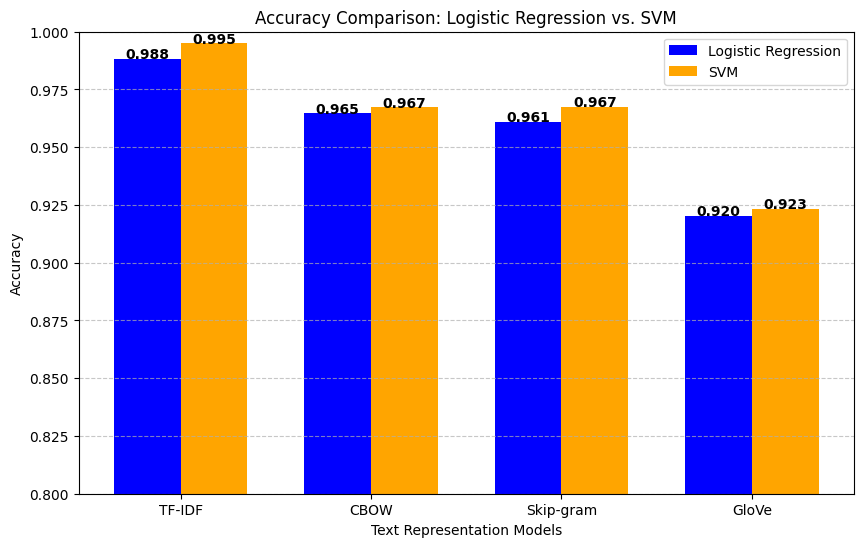

In [ ]:
models = ["TF-IDF", "CBOW", "Skip-gram", "GloVe"]

logistic_regression_accuracies = [accuracy_lr_tfidf, accuracy_lr_cbow, accuracy_lr_sg, accuracy_lr_glove]
svm_accuracies = [accuracy_svm_tfidf, accuracy_svm_cbow, accuracy_svm_sg, accuracy_svm_glove]

# set bar width and positions
bar_width = 0.35
x = np.arange(len(models))

# create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# plot bars for logistic regression and svm
bars1 = ax.bar(x - bar_width/2, logistic_regression_accuracies, bar_width, label='Logistic Regression', color='blue')
bars2 = ax.bar(x + bar_width/2, svm_accuracies, bar_width, label='SVM', color='orange')

# add value labels on top of bars
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001, 
            f'{bar.get_height():.3f}', ha='center', fontsize=10, fontweight='bold')

for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001, 
            f'{bar.get_height():.3f}', ha='center', fontsize=10, fontweight='bold')

# labels and title
ax.set_xlabel("Text Representation Models")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy Comparison: Logistic Regression vs. SVM")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0.8, 1)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend()

plt.show()


# Conclusion

This project aimed to develop a model capable of distinguishing between fake and real news by leveraging various text embedding techniques and classification models. Overall, our models performed exceptionally well, with all models achieving an accuracy of over 90%. Notably, TF-IDF performed the best, likely because it directly captures important words for classification and aligns well with traditional classifiers like Logistic Regression and SVM. 

For all methods except BERT, logistic regression performed almost as well as the support vector machine (SVM) with a linear kernel. For example, for GloVe, the accuracy for both the logistic regression model and the SVM with linear kernel was about 0.92, and for the others, SVM was only better by a marginal difference. This suggests that the simpler logistic regression model might be a preferable choice due to its lower computational cost and interpretability- given its strong performance, logistic regression offers a more efficient alternative while maintaining high classification accuracy.

A limitation of our dataset is its size. We had 40,000 articles with an equal balance of both fake and real news, which, while not problematically small, could be expanded to include more diverse sources and writing styles. This would improve generalization, particularly for real-world applications where misinformation often evolves over time. 

For future work, we could further experiment with our logistic regression and SVM model hyperparameters, as we just used the default parameters in this project. We could also explore more advanced NLP models such as FastText, which is particularly effective at handling out-of-vocabulary (OOV) words by representing words as subword components, making it more robust to misspellings and rare words. Additionally, ELMo (Embeddings from Language Models) provides contextualized word embeddings, meaning that the representation of a word dynamically changes depending on the surrounding words in a sentence.